In [100]:
import pandas as pd 
import numpy as np 
import sys 
import os 
import itertools
import collections
from sklearn.metrics import cohen_kappa_score, make_scorer
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=Warning)
import time

import matplotlib.pyplot as plt

import pylearn as pl

def move_columns(df, cols_to_move=[], ref_col="", place="After"):
    cols = df.columns.tolist()
    if place == "After":
        seg1 = cols[: list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == "Before":
        seg1 = cols[: list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]

    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    return df[seg1 + seg2 + seg3]

from scipy.stats import ks_2samp

In [101]:
restaurants = pd.read_csv("restaurants.csv")
restaurants = restaurants.dropna()

In [102]:
south_clean = pd.read_csv("listings_final.csv")
south_clean = south_clean.iloc[:,1:]
south_clean = pd.merge(south_clean, restaurants, on='id',how='left')
target = pd.read_csv("feedback_score_3.csv")
target = target.iloc[:, 1:][target["feedback_score"] < 1.0]
feature = south_clean.set_index("id")
df = feature.loc[target.set_index("id").index,:]
target = target.set_index("id").loc[df.index]
feature = df
feature = feature.reset_index().drop(columns = ["id"])
target = target.reset_index().drop(columns = ["id"])["feedback_score"]
missing_index = target.apply(np.isnan)
missing_index_res = feature["discounted_rate"].apply(np.isnan)
feature = feature.loc[~(missing_index & missing_index_res), :]
target = target.loc[~(missing_index & missing_index_res)]
feature = feature.reset_index().drop(columns = ["index"])
target = target.reset_index().drop(columns = ["index"])["feedback_score"]

In [103]:
df = pd.concat([feature, target], axis = 1)
df = df.dropna()

In [104]:
feature = df.iloc[:, :-1]
target = df.iloc[:, -1]

In [148]:
## Linear 
from sklearn.linear_model import LinearRegression, Lasso
glm = LinearRegression().fit(feature, target)

In [149]:
pred_linear = glm.predict(feature.iloc[2500:,:])
test = target[2500:]
ks_2samp(test,pred_linear)

KstestResult(statistic=0.29835390946502055, pvalue=1.7536569728262464e-19)

In [ ]:
## Logistic Regression
LG = pl.LGBoundRegressor(feature, target, log_text = "LG Bound Test")
lg_params = dict(
    penalty = ["l1", "l2"][1],
    tol = 10 ** np.arange(-5, 5, 0.5).astype(float)[0],
    C = 1.0,
    l1_ratio = None,
    solver = "liblinear"
)
lg_search_space = dict(
    penalty = hp.choice("penalty", ["l1", "l2"]),
    tol = hp.choice("tol", 10 ** np.arange(-5, 5, 0.5).astype(float)),
    C = hp.quniform("C", 0.1, 1, 0.05),
    # l1_ratio = hp.quniform("l1_ratio", 0, 1, 0.3),
    solver = hp.choice("solver", ["liblinear"])
)
## {'C': 1.0, 'penalty': 1, 'solver': 0, 'tol': 1.000934}
lg_init_vals = [
]

LG.train_model(lg_params)

In [ ]:
LG.bayes_optimize(lg_search_space, n_splits=10, max_evals = 500, init_vals = lg_init_vals)

In [ ]:
LG.evaluate_model(n_splits=10)

In [ ]:
pred = LG.predict(feature.iloc[1000:,])
test = target[1000:]
pd.Series(pred).hist(alpha = 0.5, bins = 100)
test.hist(alpha = 0.5, bins = 100)
ks_2samp(test,pred)

In [134]:
## Simple NN
nn_params = dict(
    learning_rate = 0.007516283717000085,
    num_dense_layers = 2,
    num_dense_nodes = range(60, 150, 10)[5],
    dropout = 0.19253967960332186,
    activation = ["relu", "selu", "elu"][2],
    adam_decay = 7.852560524200579e-08,
    batch_size = range(40, 160, 10)[0],
    epochs = range(100, 240, 20)[4])

nn_search_space = {
    'learning_rate' : hp.loguniform('learning_rate', np.log(1e-8), np.log(1e-1)),
    'num_dense_layers' : hp.choice('num_dense_layers', range(1, 3, 1)),
    'num_dense_nodes' : hp.choice('num_dense_nodes', range(60, 150, 10)),
    'dropout' : hp.uniform('dropout', 0.1, 0.3),
    'activation' : hp.choice('activation', ["relu", "selu", "elu"]),
    'adam_decay' : hp.loguniform('adam_decay', np.log(1e-10), np.log(1e-1)),
    'batch_size' : hp.choice('batch_size', range(40, 160, 10)),
    'epochs' : hp.choice('epochs', range(100, 240, 20)),
}
nn_init_vals = [
    {'activation': 2, 'adam_decay': 7.852560524200579e-08, 'batch_size': 0, 'dropout': 0.11410597592064128, 'epochs': 4, 'learning_rate': 0.007516283717000085, 'num_dense_layers': 1, 'num_dense_nodes': 5}
]
NN = pl.NNRegressor(feature, target, log_text = "NN Testing", verbose = 0)
NN.train_model(**nn_params)

In [62]:
NN.bayes_optimize(nn_search_space, max_evals=50, init_vals=nn_init_vals)

51trial [36:31, 42.96s/trial, best loss: 0.024168728350963023]
{'activation': 2, 'adam_decay': 7.852560524200579e-08, 'batch_size': 0, 'dropout': 0.11410597592064128, 'epochs': 4, 'learning_rate': 0.007516283717000085, 'num_dense_layers': 1, 'num_dense_nodes': 5}
0.024168728350963023


{'activation': 2,
 'adam_decay': 7.852560524200579e-08,
 'batch_size': 0,
 'dropout': 0.11410597592064128,
 'epochs': 4,
 'learning_rate': 0.007516283717000085,
 'num_dense_layers': 1,
 'num_dense_nodes': 5}

In [135]:
NN.evaluate_model(n_splits = 3)

(0.02980272286305441, -0.22832990071410517)

In [130]:
NN.model.fit(feature, target, batch_size = 50, epochs = 200, verbose = 0)

KstestResult(statistic=0.5185185185185185, pvalue=5.719044174707293e-60)

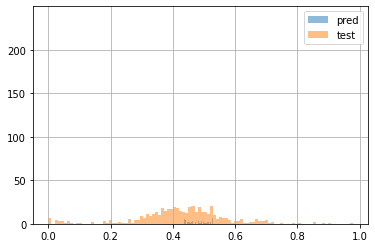

In [131]:
pred = NN.model.predict(feature.iloc[2500:, :])[:,0]
test = target.iloc[2500:]
pd.Series(pred).hist(alpha = 0.5, bins = 100, label = "pred")
test.hist(alpha = 0.5, bins = 100, label = "test")
plt.legend()
ks_2samp(test, pred)

In [136]:
RF = pl.RFRegressor(feature, target, "Random Forest Test")
rf_params = dict(
    bootstrap = True,
    ccp_alpha = 0.0,
    max_depth = 100,
    max_features = ["sqrt", "auto", "log2"][0],
    max_leaf_nodes = None,
    max_samples = None,
    min_impurity_decrease = 0.0,
    min_impurity_split = None,
    min_samples_leaf = 1,
    min_samples_split = 2,
    n_estimators = 800, 
    n_jobs = None, 
    oob_score = False, 
    random_state = None, 
    verbose = 0,
    warm_start = False
)
rf_tuning_params = dict(
    n_estimators = np.arange(100,400,100),
    max_depth = [5, 6, 7, 8],
    max_features = ["sqrt", "auto"],
)
## this is for Bayesian optimization
rf_search_space = dict(
    max_depth = hp.choice("max_depth", range(5, 40)),
    max_features = hp.choice("max_features", ["sqrt", "auto", "log2"]),
    n_estimators = hp.choice("n_estimators", range(100, 1000, 50)),
)

rf_init_vals = [
    {'max_depth': 0, 'max_features': 2, 'n_estimators': 8}
]

RF.train_model(rf_params)

RF Bound Regressor: Random Forest Test
Training Time: 12:21:53


In [60]:
RF.evaluate_model()

(0.023898616681736474, 0.03354374535697938)

KstestResult(statistic=0.10905349794238683, pvalue=0.006144354959546317)

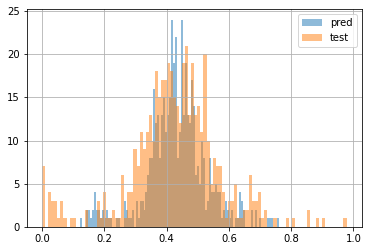

In [137]:
pred_rf = RF.predict(feature.iloc[2500:, :])
test = target.iloc[2500:]
pd.Series(pred_rf).hist(alpha = 0.5, bins = 100, label = "pred")
test.hist(alpha = 0.5, bins = 100, label = "test")
plt.legend()
ks_2samp(test, pred_rf)

In [190]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

model_names = [
    "Linear Regression", 
    "Random Forest Regression", 
    "XGBoost Regression", 
    "SVM Regression"
]

def distribution_compare_plot(y_true_list, y_pred_list):
    fig = make_subplots(
        rows = 2, cols = 2, 
        subplot_titles=tuple(model_names),
        shared_xaxes = True,
        shared_yaxes = True)
    for idx, y_pred in enumerate(y_pred_list):
        row_num = (idx // 2) + 1
        col_num = (idx % 2) + 1 
        fig.append_trace(go.Histogram(
                x = y_true_list[idx],
                name = "Index",
                nbinsx = 100,
                histnorm='probability'
            ), row = row_num, col = col_num)
        fig.append_trace(go.Histogram(
                x = y_pred,
                nbinsx = 100,
                name = f"{model_names[idx]} Prediction",
                histnorm='probability'
            ), row = row_num, col = col_num)
        fig.update_xaxes(title_text = "Index Value", row = row_num, col = col_num)
        fig.update_yaxes(title_text = "Relative Frequency", row = row_num, col = col_num)
    fig.update_traces(opacity=0.5)
    fig.update_layout(
        title = "Empirical Distribution Comparisons (Index vs. Predictions)",
        legend=dict(orientation="h"),
        font = dict(size = 10))
    fig.show()

In [161]:
## From Riya
svr_file = pd.read_csv("y_pred_svr.csv")
xgb_file = pd.read_csv("y_pred_xgb.csv")
riya_test = pd.read_csv("y_test.csv")

In [171]:
pred_svr = svr_file.reset_index()["0"].values
pred_xgb = xgb_file.reset_index()["0"].values
y_test = riya_test.reset_index()["feedback_score"].values

In [178]:
y_test_list = [test, test, y_test, y_test]
y_pred_list = [pred_linear, pred_rf, pred_xgb, pred_svr]

In [191]:
distribution_compare_plot(y_test_list, y_pred_list)

In [185]:
from sklearn.metrics import mean_squared_error, r2_score
print("RMSE:")
print(f"Linear regression: {np.sqrt(mean_squared_error(test, pred_linear))}")
print(f"Random forest regression: {np.sqrt(mean_squared_error(test, pred_rf))}")
print(f"XGBoost regression: {np.sqrt(mean_squared_error(y_test, pred_xgb))}")
print(f"SVM: {np.sqrt(mean_squared_error(y_test, pred_svr))}")

print("R-squared metrics:")
print(f"Linear regression: {r2_score(test, pred_linear)}")
print(f"Random forest regression: {r2_score(test, pred_rf)}")
print(f"XGBoost regression: {r2_score(y_test, pred_xgb)}")
print(f"SVM: {r2_score(y_test, pred_svr)}")

RMSE:
Linear regression: 0.14300167982949374
Random forest regression: 0.05239139024358445
XGBoost regression: 0.13680698503975483
SVM: 0.12989964953423153
R-squared metrics:
Linear regression: 0.05169518592353517
Random forest regression: 0.8727125685559655
XGBoost regression: -0.15690331688683323
SVM: -0.04302923388180235
